# Implementation of the Model

In [2]:
# cuda check
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1


## Data1: Dodgers data set

#### Model implementation with torch

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class TimeSeriesUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TimeSeriesUNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 16)
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)
        self.enc5 = conv_block(128, 256)

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.up4 = up_block(256, 128)
        self.up3 = up_block(128, 64)
        self.up2 = up_block(64, 32)
        self.up1 = up_block(32, 16)

        self.reduce4 = nn.Conv1d(256, 128, kernel_size=1)
        self.reduce3 = nn.Conv1d(128, 64, kernel_size=1)
        self.reduce2 = nn.Conv1d(64, 32, kernel_size=1)
        self.reduce1 = nn.Conv1d(32, 16, kernel_size=1)

        self.final = nn.Conv1d(16, out_channels, kernel_size=1)

    def crop_and_concat(self, encoder_features, decoder_features):
        _, _, H_decoder = decoder_features.shape
        encoder_features = F.interpolate(encoder_features, size=H_decoder, mode="nearest")
        return torch.cat((encoder_features, decoder_features), dim=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        # print(enc1.shape)
        enc2 = self.enc2(self.pool(enc1))
        # print(enc2.shape)
        enc3 = self.enc3(self.pool(enc2))
        # print(enc3.shape)
        enc4 = self.enc4(self.pool(enc3))
        # print(enc4.shape)
        bottleneck = self.enc5(self.pool(enc4))
        # print(bottleneck.shape)

        up4 = self.up4(bottleneck)
        # print(up4.shape)
        up4 = self.crop_and_concat(enc4, up4)
        # print(up4.shape)
        up4 = self.reduce4(up4)
        # print(up4.shape)

        up3 = self.up3(up4)
        # print(up3.shape)
        up3 = self.crop_and_concat(enc3, up3)
        # print(up3.shape)
        up3 = self.reduce3(up3)
        # print(up3.shape)

        up2 = self.up2(up3)
        # print(up2.shape)
        up2 = self.crop_and_concat(enc2, up2)
        # print(up2.shape)
        up2 = self.reduce2(up2)
        # print(up2.shape)

        up1 = self.up1(up2)
        # print(up1.shape)
        up1 = self.crop_and_concat(enc1, up1)
        # print(up1.shape)
        up1 = self.reduce1(up1)
        # print(up1.shape)

        return torch.sigmoid(self.final(up1))

#### Import data set

In [5]:
import pandas as pd

In [6]:
data_1 = pd.read_csv('data/dodgers_data.csv')
data_1.head(1)

,timestamp,count,label
0,2005-04-10 00:00:00,0.0,0


In [7]:
data_1.set_index('timestamp', inplace=True)
data_1.head(1)

,count,label
timestamp,,
2005-04-10 00:00:00,0.0,0


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import MinMaxScaler

# # Normalize the `count` column
# scaler = MinMaxScaler()
# data_1["count"] = scaler.fit_transform(data_1["count"].values.reshape(-1, 1))
data_1["count"] = data_1["count"].astype(np.float32)

# Convert to supervised data
sequence_length = 1024  # Define how many time steps per sample
X, y = [], []
for i in range(len(data_1) - sequence_length):
    X.append(data_1["count"].iloc[i:i + sequence_length].values)
    y.append(data_1["label"].iloc[i + sequence_length - 1])  # Label corresponds to the last step
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create pytorch data set

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets and DataLoaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
x, y = train_dataset[0]
print(x.shape, y.shape)

torch.Size([1, 1024]) torch.Size([1])


### Training

In [11]:
torch.cuda.is_available()

True

In [ ]:
# Define model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesUNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for anomaly detection
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = []
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Ensure target tensor is float
        y_batch = y_batch.float()

        # Expand target size to match model output
        y_batch = y_batch.unsqueeze(-1).repeat(1, 1, X_batch.shape[-1])

        # Forward pass
        outputs = model(X_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_func.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.2181
Epoch 2/10, Loss: 0.2045
Epoch 3/10, Loss: 0.1948
Epoch 4/10, Loss: 0.1887
Epoch 5/10, Loss: 0.1822
Epoch 6/10, Loss: 0.1759
Epoch 7/10, Loss: 0.1710
Epoch 8/10, Loss: 0.1677
Epoch 9/10, Loss: 0.1656
Epoch 10/10, Loss: 0.1643


### Testing the model

In [15]:
model.eval()
with torch.no_grad():
    for snapshots, masks in train_loader:
        snapshots = snapshots.to(device)
        outputs = model(snapshots)
        break

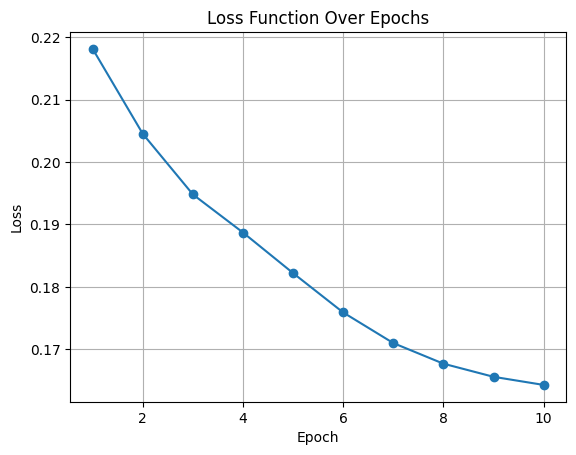

In [16]:
import matplotlib.pyplot as plt

# Assuming total_loss is a list that stores the loss value for each epoch
loss_values = [0.2181,
               0.2045,
               0.1948,
               0.1887,
               0.1822,
               0.1759,
               0.1710,
               0.1677,
               0.1656,
               0.1643
              ]

plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function Over Epochs')
plt.grid(True)
plt.show()

## Data2: GHL

#### Model implementation with torch

In [17]:
class MUNet(nn.Module):
    def __init__(self, in_channels_branch1, in_channels_branch2, out_channels):
        super(MUNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose1d(in_c, out_c, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Encoder branch 1
        self.enc1_branch1 = conv_block(in_channels_branch1, 16)
        self.enc2_branch1 = conv_block(16, 32)
        self.enc3_branch1 = conv_block(32, 64)
        self.enc4_branch1 = conv_block(64, 128)

        # Encoder branch 2
        self.enc1_branch2 = conv_block(in_channels_branch2, 16)
        self.enc2_branch2 = conv_block(16, 32)
        self.enc3_branch2 = conv_block(32, 64)
        self.enc4_branch2 = conv_block(64, 128)

        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Bottleneck
        self.bottleneck = conv_block(256, 256)

        # Decoder
        self.up4 = up_block(256, 128)
        self.dec4 = conv_block(256, 128)
        self.up3 = up_block(128, 64)
        self.dec3 = conv_block(128, 64)
        self.up2 = up_block(64, 32)
        self.dec2 = conv_block(64, 32)
        self.up1 = up_block(32, 16)
        self.dec1 = conv_block(32, 16)

        # Final output layer
        self.final = nn.Conv1d(16, out_channels, kernel_size=1)

    def crop_and_concat(self, encoder_features, decoder_features):
        _, _, H_decoder = decoder_features.shape
        encoder_features = F.interpolate(encoder_features, size=H_decoder, mode="nearest")
        return torch.cat((encoder_features, decoder_features), dim=1)

    def forward(self, x1, x2):
        # Encoder branch 1
        enc1_1 = self.enc1_branch1(x1)
        enc2_1 = self.enc2_branch1(self.pool(enc1_1))
        enc3_1 = self.enc3_branch1(self.pool(enc2_1))
        enc4_1 = self.enc4_branch1(self.pool(enc3_1))

        # Encoder branch 2
        enc1_2 = self.enc1_branch2(x2)
        enc2_2 = self.enc2_branch2(self.pool(enc1_2))
        enc3_2 = self.enc3_branch2(self.pool(enc2_2))
        enc4_2 = self.enc4_branch2(self.pool(enc3_2))

        # Bottleneck
        bottleneck = self.bottleneck(torch.cat((enc4_1, enc4_2), dim=1))

        # Decoder
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(self.crop_and_concat(torch.cat((enc4_1, enc4_2), dim=1), up4))
        up3 = self.up3(dec4)
        dec3 = self.dec3(self.crop_and_concat(torch.cat((enc3_1, enc3_2), dim=1), up3))
        up2 = self.up2(dec3)
        dec2 = self.dec2(self.crop_and_concat(torch.cat((enc2_1, enc2_2), dim=1), up2))
        up1 = self.up1(dec2)
        dec1 = self.dec1(self.crop_and_concat(torch.cat((enc1_1, enc1_2), dim=1), up1))

        return torch.sigmoid(self.final(dec1))

### Import data set

In [18]:
data_2 = pd.read_csv('data/ghl_data.csv')
data_2_b = pd.read_csv('data/ghl_data_b.csv')

In [19]:
data_2.head(1)

,Time,RT_level_ini,DANGER,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,C_level,...,HT_level,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
0,0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,0.0,...,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
data_2.set_index('Time', inplace=True)
data_2_b.set_index('Time', inplace=True)

data_2.head(1)

,RT_level_ini,DANGER,RT_temperature.T,C_temperature.T,RT_level,dT_rand,limiter.y,dt_rand,C_level,HT_temperature.T,HT_level,limiter1.y,dL_rand,out_valve_act_1.0,inv_valve_act_1.0,inj_valve_act_1.0,Relaxing.active_1.0,boundary.m_flow_in_20.0,dir_valve_act_1.0,heater_act_1.0
Time,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.002441,0.0,0.0,0.461757,0.35503,0.500675,0.0,0.0,0.0,0.500675,0.461757,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data preparation

In [21]:
labels = data_2['DANGER'].values
data_2 = data_2.drop(columns=['DANGER'])

In [22]:
data1_train, data1_test, data2_train, data2_test, labels_train, labels_test = train_test_split(
    data_2, data_2, labels, test_size=0.2, random_state=42)

In [23]:
import torch
from torch.utils.data import Dataset

class GHLDataset(Dataset):
    def __init__(self, data1, data2, labels):
        """
        Args:
            data1 (numpy.ndarray): First data stream, shape [num_samples, sequence_length].
            data2 (numpy.ndarray): Second data stream, shape [num_samples, sequence_length].
            labels (numpy.ndarray): Target labels, shape [num_samples, sequence_length].
        """
        self.data1 = data1
        self.data2 = data2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x1 = torch.tensor(self.data1[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dim
        x2 = torch.tensor(self.data2[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dim
        y = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dim
        return x1, x2, y


In [24]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = GHLDataset(data1_train, data2_train, labels_train)
test_dataset = GHLDataset(data1_test, data2_test, labels_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MUNet(in_channels_branch1=1, in_channels_branch2=1, out_channels=1).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func_munet = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x1, x2, y in train_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        # Forward pass
        outputs = model(x1, x2)
        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_func_munet.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

### Evaluate the model

In [ ]:
model.eval()
test_loss = 0

with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        outputs = model(x1, x2)
        loss = criterion(outputs, y)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

## Data3: EMG data set

### Import data set

In [32]:
data_3 = pd.read_csv(r'data\emg_data.csv')

In [33]:
data_3.head(1)

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,target
0,1,0.470588,0.436681,0.412844,0.437229,0.501961,0.464435,0.461864,0.431111,0


In [35]:
data_3.set_index('time', inplace=True)
data_3.head(1)

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,target
time,,,,,,,,,
1,0.470588,0.436681,0.412844,0.437229,0.501961,0.464435,0.461864,0.431111,0
